# Telco Churn Report

By Jeremy Lagunas 07/15/2022

## Project Description
I will be working with the Telco dataset to accomplish gaining an underestanding of the company's churn drivers and what can be done to address them. 

## Initial Questions
- What drives churn?
- What actionable items can be taken to address the churn drivers?

## Project Goals
- Find churn drivers
- Compare churn drivers
- Generate visuals to communicate this information
- Generate models which can accurately predict churn
- Communicate recommendations to address customer churn

## Wrangle Telco Data

To acquire the Telco data, I used the telco_churn database in the Codeup mySQL server. I selected all columns from the customers table and joined contract_types, internet_service_types, and payment_types, using their respective _type_id.

In [4]:
# acquire data from sql database 
import acquire

In [11]:
df = acquire.get_telco_data()

To clean the data, I used the prep_telco() function from the prepare file. 

In [7]:
import prepare

In [12]:
df = prepare.prep_telco(df)

I mapped all remaining categorical variables from Yes/No to 1/0

In [13]:
df['partner'] = df['partner'].map({'Yes':1, 'No':0})
df['dependents'] = df['dependents'].map({'Yes':1, 'No':0})
df['phone_service'] = df['phone_service'].map({'Yes':1, 'No':0})
df['multiple_lines'] = df['multiple_lines'].map({'Yes':1, 'No':0, 'No phone service':0})
df['online_security'] = df['online_security'].map({'Yes':1, 'No':0, 'No internet service':0})
df['online_backup'] = df['online_backup'].map({'Yes':1, 'No':0, 'No internet service':0})
df['device_protection'] = df['device_protection'].map({'Yes':1, 'No':0, 'No internet service':0})
df['tech_support'] = df['tech_support'].map({'Yes':1, 'No':0, 'No internet service':0})
df['streaming_tv'] = df['streaming_tv'].map({'Yes':1, 'No':0, 'No internet service':0})
df['streaming_movies'] = df['streaming_movies'].map({'Yes':1, 'No':0, 'No internet service':0})
df['paperless_billing'] = df['paperless_billing'].map({'Yes':1, 'No':0})
df['churn'] = df['churn'].map({'Yes':1, 'No':0})
df['gender'] = df['gender'].map({'Male':1, 'Female':0})

I dropped the customer_id column and I dropped the 11 instances where total_charge was blank and tenure = 0.

In [14]:
df = df.drop(columns = ['customer_id']) 
df = df.drop([945, 1731, 1906, 2025, 2176, 2250, 2855, 3052, 3118, 4054, 5433])

I changed total_charges from objects to floats.

In [15]:
df['total_charges'] = pd.to_numeric(df['total_charges'])

Lastly, I split the data into train, validate, and test groups using the train_validate_test_split function from the prepare file. 

In [17]:
train, validate, test = prepare.train_validate_test_split(df, 'churn', seed=123)

## Exploratory Analysis

What drives churn?

During my analysis, I found three variables which appeared to have a significant relationship with customer churn rates. 
Those three variables being:
- Fiber Optic Internet Service
- Month-to-month subscribers
- E-check payment users

The following three graphs display the curn rates between internet service types, contract types, and payment types, while also comparing them all with the overall customer churn rate of 27%

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

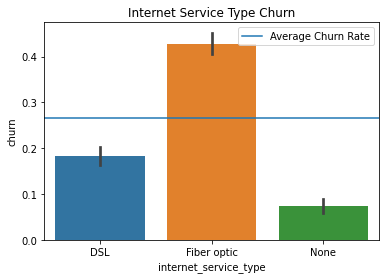

In [20]:
plt.title('Internet Service Type Churn')
sns.barplot(x='internet_service_type', y= 'churn', data=train)
rate = train.churn.mean()
plt.axhline(rate, label = 'Average Churn Rate')
plt.legend()
plt.show()

Takeaway:
Our Fiber service may be overpriced or not meeting performance and reliability standards for our customers. 

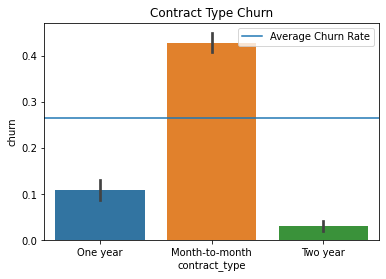

In [21]:
plt.title('Contract Type Churn')
sns.barplot(x='contract_type', y= 'churn', data=train)
rate = train.churn.mean()
plt.axhline(rate, label = 'Average Churn Rate')
plt.legend()
plt.show()

Takeaway:
    Month-to-month customers have many more chances to discontinue using our services. We should prioritize turning M2M into longer contracted customers. 

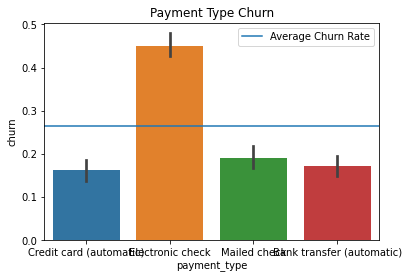

In [22]:
plt.title('Payment Type Churn')
sns.barplot(x='payment_type', y= 'churn', data=train)
rate = train.churn.mean()
plt.axhline(rate, label = 'Average Churn Rate')
plt.legend()
plt.show()

Takeaway:
Our E-check payment option may be difficult to use, causing frustration among customers and pushing them to leave. We should investigate this and see if it can be improved or consider getting rid of that payment option.

Further Recommendations

- Conduct market research to compare our Fiber optic pricing and performance with our competitors.
- Test using incentives to establish long-term contracts with customers. 

## Model

I tested several models to predict churn. In the end, the Random Forest Model performed the best on the Validate and Test datasets.

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
# Dropping remaining columns with objects for modeling
train_model = train.drop(columns = ['contract_type', 'internet_service_type', 'payment_type'])
validate_model = validate.drop(columns = ['contract_type', 'internet_service_type', 'payment_type'])
test_model = test.drop(columns = ['contract_type', 'internet_service_type', 'payment_type'])

In [30]:
# Establishing the x and y groups for my train, validate, and test data
x_train = train_model.drop(columns = ['churn'])
y_train = train_model.churn

x_validate = validate_model.drop(columns = ['churn'])
y_validate = validate_model.churn

x_test = test_model.drop(columns = ['churn'])
y_test = test_model.churn

In [33]:
# Turning y datasets from 0/1 to No/Yes for modeling.
y_train = np.where(y_train == 0, 'No', 'Yes')
y_validate = np.where(y_validate == 0, 'No', 'Yes')
y_test = np.where(y_test == 0, 'No', 'Yes')

In [34]:
rf = RandomForestClassifier(bootstrap = True,
                            class_weight = None,
                            criterion = 'gini',
                            min_samples_leaf = 3,
                            n_estimators = 100,
                            max_depth = 3,
                            random_state = 123)

In [35]:
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [38]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(x_train, y_train)))

Accuracy of random forest classifier on training set: 0.79


In [39]:
# Validate
print('Accuracy of random forest classifier on validate set: {:.2f}'
 .format(rf.score(x_validate, y_validate)))

Accuracy of random forest classifier on validate set: 0.77


In [40]:
# Test
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(x_test, y_test)))

Accuracy of random forest classifier on test set: 0.79


## Conclusion

### Summary

- I discussed the purpose of this project and asked a few questions to try and answer. 
- I found that Fiber Optic Internet, Month-to-month subscriptions, and E-check use all contribute to churn at a much higher rate than the overall churn rate. 
- I reviewed the model I worked with.

### Recommendations / Next Steps

To recap:

1. I believe we should conduct more thorough market research with regard to our Fiber Internet service. We should look to see how how pricing and performance compare with our competitors. 
2. Prioritize converting our Month-to-month customers into long-term contract customers.
3. Consider improving the E-check payment experience, or discarding it all together. 